# Freddie Mac Single Family Loan Classification Project

## Aim: To predict whether a loan is good or bad using data collected when the loan is originated.

## Dataset: Single Family Loan-Level dataset downloaded from Freddie Mac's website
http://www.freddiemac.com/research/datasets/sf_loanlevel_dataset.page
Year range: 1999-2003
Only completed/terminated loans are used. A good loan is a loan that has been fully paid-off; a bad loan is a loan that was terminated by other reasons. Raw data is a stored in sqlite database.


In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import pandas_profiling
import os
import numpy as np
from scipy import stats

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
#PROJECT_ROOT_DIR = "."
#CHAPTER_ID = "unsupervised_learning"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(fig_id + ".png") #os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
import sqlite3
path = 'C:/Users/tsofo/Desktop/data_sci_proj/freddie/freddie_1999.db'
conn = sqlite3.connect(path)

q1 = '''
select *
from ORIG_1999_2003
where Credit_Score != 9999 AND
    Orig_CLTV != 999 AND
    Orig_DTI_Ratio != 999 AND
    Orig_LTV != 999 AND
    Channel != 9 AND
    Property_Type !=99 AND
    Loan_Purpose != 9 AND
    Num_Borrowers != 99 
'''
df = pd.read_sql_query(q1,conn) # query loan origination data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7059618 entries, 0 to 7059617
Data columns (total 26 columns):
Credit_Score                 int64
First_Payment                int64
First_Time_Homebuyer_Flag    object
Maturity_Date                int64
MSA_Code                     float64
MI_pert                      int64
Num_Units                    int64
Occc_Status                  object
Orig_CLTV                    int64
Orig_DTI_Ratio               int64
Orig_UPB                     int64
Orig_LTV                     int64
Orig_Interest_Rate           float64
Channel                      object
PPM_Flag                     object
Product_Type                 object
Property_State               object
Property_Type                object
Postal_Code                  float64
Loan_Seq_Num                 object
Loan_Purpose                 object
Orig_Loan_Term               int64
Num_Borrowers                int64
Seller_Name                  object
Servicer_Name                ob

Columns in Loan Origination Data:
Credit Score
First Payment Date
First Time HomeBuyer Flag
Maturity Date
MSA (Metropolitain Statistical Area ) Code
Mortgage Insurance Percentage
Number of units
Occupancy Status: Primary Residence, Investment or second home
Original Combined Loan-to-value (CLTV)
Original Debt-to-income (DTI) Ratio
Original Unpaid Balance (UPB)
Original Loan-to-value (LTV)
Original Interest rate
Channel: R= retail, B = Broker, C = correspondent, T = third party not specified
Prepayment penalty mortgage (PPM) flag
Product type: all are fixed rate mortgate
Property State: AL, CA et...
Property type: CO=condo, PU=planned unit developemnt,MH=manufactured housing, SF = single-family, CP = co-op
Postal Code
Loan Sequence Number: the unique identifier of the loan
Loan purpose: P=purchase, C=refinance-cash out,N=refinance-no cash out, r = refinance-not specified
oringinal loan term
number of burrowers: 1 or more
seller name
servicer name
superconforming flag: For mortgages that exceed conforming loan limits with origination dates on or after 10/1/2008 and settlements on or after 1/1/2009

In [3]:
# preprocessing here aims to:
# 1. map values to the from letter to numeric values in true vs false columns
# 2. clear NaN fields
# 3. label encode catagorial fields
from sklearn import preprocessing
unused_columns = ['Loan_Seq_Num']
lbl_dict = {}
for c in df.columns:
    print(c)
    if c == "First_Time_Homebuyer_Flag": 
        df[c] =df[c].map({'N':0,'Y':1, '9': np.nan})
        #df[c] = df[c].astype('int64')
    elif c == "MI_pert": 
        df.loc[df[c] == '999', c] = np.nan
    elif c == "Num_Units": 
        df.loc[df[c] == '99', c] = np.nan
    
    elif c == "MSA_Code": 
        df[c] =df[c].fillna(0)
    elif c == "Postal_Code": 
        df[c] =df[c].fillna(0)
    elif c == "PPM_Flag": 
        df[c] =df[c].map({'N':0,'Y':1})
    
    if (df[c].dtype=='object' or c == "Postal_Code" or c =="MSA_Code")and c not in unused_columns: 
        print('L')
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df[c].values))
        lbl_dict[c] = lbl
        df[c] = lbl.transform(list(df[c].values))

Credit_Score
First_Payment
First_Time_Homebuyer_Flag
Maturity_Date
MSA_Code
L
MI_pert


C:\Users\tsofo\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


Num_Units
Occc_Status
L
Orig_CLTV
Orig_DTI_Ratio
Orig_UPB
Orig_LTV
Orig_Interest_Rate
Channel
L
PPM_Flag
Product_Type
L
Property_State
L
Property_Type
L
Postal_Code
L
Loan_Seq_Num
Loan_Purpose
L
Orig_Loan_Term
Num_Borrowers
Seller_Name
L
Servicer_Name
L
Super_Conforming_Flag
L


In [4]:
q2 = '''
SELECT Loan_Seq_Num, Zero_Balance_Code
from SVCG_1999_2003
WHERE Zero_Balance_Code is NOT NULL
'''
df1 = pd.read_sql_query(q2,conn) # query all terminated laon from loan status data
#df1.head()


In [5]:
df1.Zero_Balance_Code.value_counts()

1     6858371
9       99494
2       19711
6       17224
3       12745
15       9393
Name: Zero_Balance_Code, dtype: int64

Good Loans (0)
0: Matured (voluntary paid off)
Bad Loans (1)
2: third party sale
3: short sale or charge off
6: repurchase prior to property disposition
9: REO disposition

In [6]:
df1['Bad_Loans'] = df1.Zero_Balance_Code.map({1: 0, 9: 1, 6: 1, 3: 1, 2: 1})

In [7]:
df1.head()

,Loan_Seq_Num,Zero_Balance_Code,Bad_Loans
0,F199Q1000001,1,0.0
1,F199Q1000002,1,0.0
2,F199Q1000003,1,0.0
3,F199Q1000004,1,0.0
4,F199Q1000005,1,0.0


In [8]:
result  =pd.merge(df,df1,on = 'Loan_Seq_Num',how = 'right')

In [9]:
result = result.dropna()#subset = ['PPM_Flag','Postal_Code','MSA_Code','Super_Conforming_Flag'])

In [10]:
result.isna().sum()

Credit_Score                 0
First_Payment                0
First_Time_Homebuyer_Flag    0
Maturity_Date                0
MSA_Code                     0
MI_pert                      0
Num_Units                    0
Occc_Status                  0
Orig_CLTV                    0
Orig_DTI_Ratio               0
Orig_UPB                     0
Orig_LTV                     0
Orig_Interest_Rate           0
Channel                      0
PPM_Flag                     0
Product_Type                 0
Property_State               0
Property_Type                0
Postal_Code                  0
Loan_Seq_Num                 0
Loan_Purpose                 0
Orig_Loan_Term               0
Num_Borrowers                0
Seller_Name                  0
Servicer_Name                0
Super_Conforming_Flag        0
Zero_Balance_Code            0
Bad_Loans                    0
dtype: int64

In [11]:
result.shape

(5093488, 28)

In [12]:
#result['Bad_Loans'] = result['Bad_Loans'].fillna(0)
result['Bad_Loans'].value_counts()


0.0    4983029
1.0     110459
Name: Bad_Loans, dtype: int64

In [13]:
result['year'] = result['First_Payment']//100


In [14]:
#import pandas_profiling
#pandas_profiling.ProfileReport(result)

In [15]:
result['year'].value_counts()

2003.0    1317387
2002.0    1221197
2001.0    1099707
1999.0     701747
2000.0     607808
2004.0     143826
2005.0       1193
2006.0        314
2007.0        195
2008.0        108
2009.0          4
2013.0          1
2011.0          1
Name: year, dtype: int64

Index(['Credit_Score', 'First_Payment', 'First_Time_Homebuyer_Flag',
       'Maturity_Date', 'MSA_Code', 'MI_pert', 'Num_Units', 'Occc_Status',
       'Orig_CLTV', 'Orig_DTI_Ratio', 'Orig_UPB', 'Orig_LTV',
       'Orig_Interest_Rate', 'Channel', 'PPM_Flag', 'Product_Type',
       'Property_State', 'Property_Type', 'Postal_Code', 'Loan_Seq_Num',
       'Loan_Purpose', 'Orig_Loan_Term', 'Num_Borrowers', 'Seller_Name',
       'Servicer_Name', 'Super_Conforming_Flag'],
      dtype='object')

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

def split_n_transform(df, features):
    X_pre = df[features]
    y = df['Bad_Loans']
    num_pipeline = Pipeline([
        #('imputer', SimpleImputer(strategy="median")),
        #('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()),
    ])
    X = num_pipeline.fit_transform(X_pre)
    return X, y

In [38]:
result.columns

Index(['Credit_Score', 'First_Payment', 'First_Time_Homebuyer_Flag',
       'Maturity_Date', 'MSA_Code', 'MI_pert', 'Num_Units', 'Occc_Status',
       'Orig_CLTV', 'Orig_DTI_Ratio', 'Orig_UPB', 'Orig_LTV',
       'Orig_Interest_Rate', 'Channel', 'PPM_Flag', 'Product_Type',
       'Property_State', 'Property_Type', 'Postal_Code', 'Loan_Seq_Num',
       'Loan_Purpose', 'Orig_Loan_Term', 'Num_Borrowers', 'Seller_Name',
       'Servicer_Name', 'Super_Conforming_Flag', 'Zero_Balance_Code',
       'Bad_Loans', 'year'],
      dtype='object')

In [40]:
features = result.columns.drop(['Zero_Balance_Code','Bad_Loans','year','Loan_Seq_Num'])
features_no_geo = result.columns.drop(['Zero_Balance_Code','Bad_Loans','year','MSA_Code','Postal_Code','Loan_Seq_Num','Property_State'])
features_no_geo1 = result.columns.drop(['Zero_Balance_Code','Bad_Loans','year','MSA_Code','Postal_Code','Loan_Seq_Num','Property_State','Servicer_Name','Seller_Name'])
features_no_credit_score = result.columns.drop(['Zero_Balance_Code','Bad_Loans','year','Loan_Seq_Num','Credit_Score'])

In [18]:
future_df = result[result['year']==2003]
old_df = result[result['year']<2003]

In [19]:
old_X,old_y = split_n_transform(old_df,features)
future_X,future_y = split_n_transform(future_df,features)

In [20]:
def subsample_data(df):
    shuffle = df.sample(frac=1,random_state=4)
    shuffle_bad = shuffle.loc[shuffle['Bad_Loans'] == 1]
    shuffle_good_subsample = shuffle.loc[shuffle['Bad_Loans'] == 0].sample(n=len(shuffle_bad),random_state=42)
    combined = pd.concat([shuffle_good_subsample, shuffle_bad])
    return combined.sample(frac=1,random_state=4)

In [21]:
old_under_sample = subsample_data(old_df)
old_X_under, old_y_under = split_n_transform(old_under_sample, features)
future_under_sample = subsample_data(future_df)
future_X_under, future_y_under = split_n_transform(future_under_sample, features)

In [22]:
from imblearn.over_sampling import SMOTE

def over_sample(df):
# Resample the minority class. You can change the strategy to 'auto' if you are not sure.
    sm = SMOTE(sampling_strategy='minority', random_state=7)
    #print(df[features].head(),df['Bad_Loans'].head())
# Fit the model to generate the data.
    over_X, over_y= sm.fit_sample(df[features], df['Bad_Loans'])
    #print('abc')
    oversampled = pd.concat([pd.DataFrame(over_X), pd.DataFrame(over_y)], axis=1)
    #print('ok')
    return oversampled.sample(frac=1,random_state=4)

Using TensorFlow backend.


In [23]:
old_over_sample = over_sample(old_df)
old_X_over, old_y_over = split_n_transform(old_over_sample, features)
future_over_sample = over_sample(future_df)
future_X_over, future_y_over = split_n_transform(future_over_sample, features)

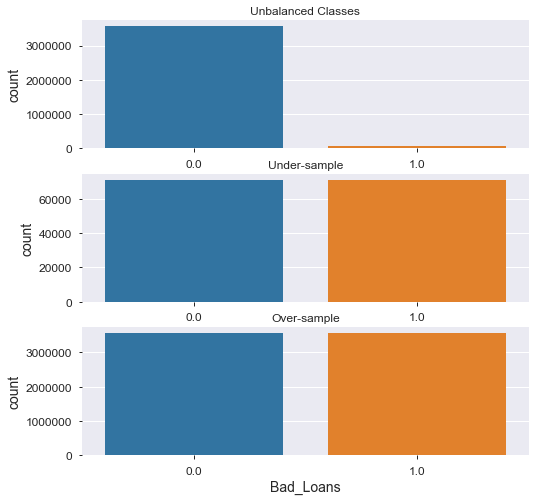

Saving figure balance_count


<Figure size 432x288 with 0 Axes>

In [24]:
#plot the dataset after the undersampling
plt.figure(figsize=(8, 8))
plt.subplot(311)
sns.countplot('Bad_Loans', data=old_df)
plt.title('Unbalanced Classes')
plt.subplot(312)
sns.countplot('Bad_Loans', data=old_under_sample)
plt.title('Under-sample')
plt.subplot(313)
sns.countplot('Bad_Loans', data=old_over_sample)
plt.title('Over-sample')
plt.show()
save_fig('balance_count')

In [25]:
from sklearn.metrics import *
def prediction_summary_balanced(clf_name,session_name,y, pred):
    print(clf_name,'\n',session_name,'\n Accuracy:',accuracy_score(y, pred),
         'ROC AUC:',roc_auc_score(y, pred), '\n','F1 Score:',f1_score(y, pred),'Matthews CC:',matthews_corrcoef(y,pred),'\n',
         'Precision Recall fscore support',precision_recall_fscore_support(y,pred),'\n',confusion_matrix(y, pred))

In [26]:
from sklearn.metrics import *
def prediction_summary_imbalanced(clf_name,session_name,y, pred):
    print(clf_name,'\n',session_name,'\n Balanced Accuracy Score:',balanced_accuracy_score(y, pred),
         'ROC AUC:',roc_auc_score(y, pred), '\n','F1 Score:',f1_score(y, pred),'Matthews CC:',matthews_corrcoef(y,pred),'\n',
         'Precision Recall fscore support',precision_recall_fscore_support(y,pred),'\n',confusion_matrix(y, pred))

In [27]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
import time

def classification_balanced(train_X, train_y, test_X,test_y):
    gbrt_clf = GradientBoostingClassifier(n_estimators=10, random_state=42)
    sgd_clf = SGDClassifier(random_state = 42)
    rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
    ada_clf = AdaBoostClassifier(random_state = 42)
    
    voting_clf = VotingClassifier(
    estimators=[('sgd', sgd_clf), ('rf', rnd_clf),('gb',gbrt_clf),('ada',ada_clf)],
    voting='hard')
    voting_clf.fit(train_X, train_y)
    
    y_pred_train_all = pd.DataFrame(data = pd.Series(train_y))
    y_pred_test_all= pd.DataFrame(data = pd.Series(test_y))

    

    for clf in (sgd_clf,rnd_clf,gbrt_clf,ada_clf, voting_clf):
        start_time = time.time()
        clf.fit(train_X, train_y)
        y_pred_train = clf.predict(train_X)
        y_pred_test = clf.predict(test_X)
       
        y_pred_train_all[clf.__class__.__name__] = pd.Series(y_pred_train).values
        y_pred_test_all[clf.__class__.__name__] = pd.Series(y_pred_test).values
                   
        prediction_summary_balanced(clf.__class__.__name__,'Training', train_y,y_pred_train)
        prediction_summary_balanced(clf.__class__.__name__,'Testing',test_y, y_pred_test)    
        print("--- %s seconds ---" % (time.time() - start_time))    

In [28]:
import lightgbm as lgb

def call_lgb(old_df,future_df,features,is_unbalanced_flag=False,valid_fraction = 0.1):
    valid_rows = int(len(old_df) * valid_fraction)
    train = old_df[:-valid_rows ]
    # valid size == test size, last two sections of the data
    valid = old_df[-valid_rows :]
    #test = result_simple_lgb[-valid_rows:]
    test = future_df
    dtrain = lgb.Dataset(train[features], label=train['Bad_Loans'])
    dvalid = lgb.Dataset(valid[features], label=valid['Bad_Loans'])
    dtest = lgb.Dataset(test[features], label=test['Bad_Loans'])

    param = {'num_leaves': 64, 'objective': 'binary','learning_rate':0.1,'is_unbalance': is_unbalanced_flag} 
    param['metric'] = 'auc'
    num_round = 1000
    bst = lgb.train(param, dtrain, num_round, valid_sets=[dvalid], early_stopping_rounds=10)


    ypred_lgb_train = bst.predict(train[features], num_iteration=bst.best_iteration)
    ypred_lgb_valid = bst.predict(valid[features], num_iteration=bst.best_iteration)
    ypred_lgb_test = bst.predict(test[features], num_iteration=bst.best_iteration)   

    importance = pd.DataFrame(data = bst.feature_importance(), index = bst.feature_name(), columns = ['Importance'])
    print(importance.sort_values(by='Importance', ascending = False))
    
    if is_unbalanced_flag == True:
        prediction_summary_imbalanced('Light LGB', 'Training', train['Bad_Loans'], ypred_lgb_train > 0.5)
        prediction_summary_imbalanced('Light LGB','Valdiation', valid['Bad_Loans'], ypred_lgb_valid > 0.5)
        prediction_summary_imbalanced('Light LGB','Testing',test['Bad_Loans'], ypred_lgb_test > 0.5)
    else:
        prediction_summary_balanced('Light LGB', 'Training', train['Bad_Loans'], ypred_lgb_train > 0.5)
        prediction_summary_balanced('Light LGB','Valdiation', valid['Bad_Loans'], ypred_lgb_valid > 0.5)
        prediction_summary_balanced('Light LGB','Testing',test['Bad_Loans'], ypred_lgb_test > 0.5)


In [29]:
classification_balanced(old_X_under, old_y_under, future_X_under, future_y_under)

SGDClassifier 
 Training 
 Accuracy: 0.7802788900795218 ROC AUC: 0.7802788900795218 
 F1 Score: 0.7808027456799849 Matthews CC: 0.5605641835612997 
 Precision Recall fscore support (array([0.78162499, 0.7789456 ]), array([0.77788901, 0.78266877]), array([0.77975252, 0.78080275]), array([70924, 70924], dtype=int64)) 
 [[55171 15753]
 [15414 55510]]
SGDClassifier 
 Testing 
 Accuracy: 0.7153043630731465 ROC AUC: 0.7153043630731465 
 F1 Score: 0.7154872813294005 Matthews CC: 0.43060908212506016 
 Precision Recall fscore support (array([0.71558157, 0.71502787]), array([0.71466145, 0.71594728]), array([0.71512121, 0.71548728]), array([34219, 34219], dtype=int64)) 
 [[24455  9764]
 [ 9720 24499]]
--- 2.3299667835235596 seconds ---
RandomForestClassifier 
 Training 
 Accuracy: 0.9896579437143985 ROC AUC: 0.9896579437143985 
 F1 Score: 0.989609230573086 Matthews CC: 0.9793589379376652 
 Precision Recall fscore support (array([0.98510944, 0.99429255]), array([0.99434606, 0.98496983]), array([0.

In [30]:
call_lgb(old_under_sample, future_under_sample,features)

[1]	valid_0's auc: 0.845957
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.851609
[3]	valid_0's auc: 0.855552
[4]	valid_0's auc: 0.859449
[5]	valid_0's auc: 0.860929
[6]	valid_0's auc: 0.863309
[7]	valid_0's auc: 0.865399
[8]	valid_0's auc: 0.867449
[9]	valid_0's auc: 0.86851
[10]	valid_0's auc: 0.870569
[11]	valid_0's auc: 0.872184
[12]	valid_0's auc: 0.873301
[13]	valid_0's auc: 0.874694
[14]	valid_0's auc: 0.876249
[15]	valid_0's auc: 0.877518
[16]	valid_0's auc: 0.878821
[17]	valid_0's auc: 0.880344
[18]	valid_0's auc: 0.881055
[19]	valid_0's auc: 0.881977
[20]	valid_0's auc: 0.883077
[21]	valid_0's auc: 0.884106
[22]	valid_0's auc: 0.884898
[23]	valid_0's auc: 0.886021
[24]	valid_0's auc: 0.886898
[25]	valid_0's auc: 0.887384
[26]	valid_0's auc: 0.888253
[27]	valid_0's auc: 0.889267
[28]	valid_0's auc: 0.890295
[29]	valid_0's auc: 0.890919
[30]	valid_0's auc: 0.891527
[31]	valid_0's auc: 0.892187
[32]	valid_0's auc: 0.892849
[33]	valid_0's auc: 0

In [86]:
call_lgb(old_under_sample, future_under_sample,features_no_geo1)

[1]	valid_0's auc: 0.841385
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.846148
[3]	valid_0's auc: 0.848697
[4]	valid_0's auc: 0.852257
[5]	valid_0's auc: 0.855168
[6]	valid_0's auc: 0.856292
[7]	valid_0's auc: 0.857681
[8]	valid_0's auc: 0.858923
[9]	valid_0's auc: 0.859024
[10]	valid_0's auc: 0.860099
[11]	valid_0's auc: 0.86094
[12]	valid_0's auc: 0.861144
[13]	valid_0's auc: 0.862232
[14]	valid_0's auc: 0.862909
[15]	valid_0's auc: 0.863458
[16]	valid_0's auc: 0.864224
[17]	valid_0's auc: 0.864876
[18]	valid_0's auc: 0.865332
[19]	valid_0's auc: 0.865846
[20]	valid_0's auc: 0.86639
[21]	valid_0's auc: 0.866844
[22]	valid_0's auc: 0.86716
[23]	valid_0's auc: 0.867702
[24]	valid_0's auc: 0.868131
[25]	valid_0's auc: 0.868559
[26]	valid_0's auc: 0.868906
[27]	valid_0's auc: 0.869143
[28]	valid_0's auc: 0.869428
[29]	valid_0's auc: 0.869778
[30]	valid_0's auc: 0.869972
[31]	valid_0's auc: 0.870301
[32]	valid_0's auc: 0.870538
[33]	valid_0's auc: 0.8

In [87]:
call_lgb(old_under_sample, future_under_sample,features_no_credit_score)

[1]	valid_0's auc: 0.824031
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.830106
[3]	valid_0's auc: 0.835344
[4]	valid_0's auc: 0.836364
[5]	valid_0's auc: 0.839046
[6]	valid_0's auc: 0.840911
[7]	valid_0's auc: 0.842686
[8]	valid_0's auc: 0.844223
[9]	valid_0's auc: 0.845707
[10]	valid_0's auc: 0.846758
[11]	valid_0's auc: 0.849187
[12]	valid_0's auc: 0.850339
[13]	valid_0's auc: 0.852402
[14]	valid_0's auc: 0.853858
[15]	valid_0's auc: 0.85475
[16]	valid_0's auc: 0.855568
[17]	valid_0's auc: 0.85663
[18]	valid_0's auc: 0.858127
[19]	valid_0's auc: 0.859538
[20]	valid_0's auc: 0.860557
[21]	valid_0's auc: 0.861374
[22]	valid_0's auc: 0.861983
[23]	valid_0's auc: 0.862917
[24]	valid_0's auc: 0.863742
[25]	valid_0's auc: 0.864854
[26]	valid_0's auc: 0.865414
[27]	valid_0's auc: 0.866189
[28]	valid_0's auc: 0.867899
[29]	valid_0's auc: 0.868672
[30]	valid_0's auc: 0.86915
[31]	valid_0's auc: 0.869697
[32]	valid_0's auc: 0.870888
[33]	valid_0's auc: 0.8

In [32]:
classification_balanced(old_X_over, old_y_over, future_X_over, future_y_over)

SGDClassifier 
 Training 
 Accuracy: 0.7995923624855493 ROC AUC: 0.7995923624855493 
 F1 Score: 0.8059693901003747 Matthews CC: 0.6004833894741016 
 Precision Recall fscore support (array([0.82067075, 0.78111412]), array([0.76672627, 0.83245845]), array([0.79278191, 0.80596939]), array([3559535, 3559535], dtype=int64)) 
 [[2729189  830346]
 [ 596370 2963165]]
SGDClassifier 
 Testing 
 Accuracy: 0.7287366112621262 ROC AUC: 0.7287366112621263 
 F1 Score: 0.7349490022223603 Matthews CC: 0.45797668930652075 
 Precision Recall fscore support (array([0.73998644, 0.71849427]), array([0.70529814, 0.75217509]), array([0.72222601, 0.734949  ]), array([1283168, 1283168], dtype=int64)) 
 [[905016 378152]
 [318001 965167]]
--- 75.3888475894928 seconds ---
RandomForestClassifier 
 Training 
 Accuracy: 0.9985189076663104 ROC AUC: 0.9985189076663104 
 F1 Score: 0.9985167587690448 Matthews CC: 0.9970420008783234 
 Precision Recall fscore support (array([0.99707859, 0.9999676 ]), array([0.99996769, 0.99

In [33]:
call_lgb(old_over_sample, future_over_sample,features)

[1]	valid_0's auc: 0.967291
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.970016
[3]	valid_0's auc: 0.972571
[4]	valid_0's auc: 0.975074
[5]	valid_0's auc: 0.975897
[6]	valid_0's auc: 0.978715
[7]	valid_0's auc: 0.980104
[8]	valid_0's auc: 0.980968
[9]	valid_0's auc: 0.981802
[10]	valid_0's auc: 0.982781
[11]	valid_0's auc: 0.983445
[12]	valid_0's auc: 0.984592
[13]	valid_0's auc: 0.985277
[14]	valid_0's auc: 0.985853
[15]	valid_0's auc: 0.986397
[16]	valid_0's auc: 0.987733
[17]	valid_0's auc: 0.988031
[18]	valid_0's auc: 0.98864
[19]	valid_0's auc: 0.988997
[20]	valid_0's auc: 0.989607
[21]	valid_0's auc: 0.989933
[22]	valid_0's auc: 0.990529
[23]	valid_0's auc: 0.990899
[24]	valid_0's auc: 0.991286
[25]	valid_0's auc: 0.991726
[26]	valid_0's auc: 0.992312
[27]	valid_0's auc: 0.992677
[28]	valid_0's auc: 0.993006
[29]	valid_0's auc: 0.993255
[30]	valid_0's auc: 0.993578
[31]	valid_0's auc: 0.993842
[32]	valid_0's auc: 0.994025
[33]	valid_0's auc: 0

Light LGB 
 Training 
 Accuracy: 0.9901944120978349 ROC AUC: 0.9901944344945766 
 F1 Score: 0.9901109632217111 Matthews CC: 0.9805285671590571 
 Precision Recall fscore support (array([0.98205612, 0.99861216]), array([0.99863559, 0.98175328]), array([0.99027646, 0.99011096]), array([3203573, 3203590], dtype=int64)) 
 [[3199202    4371]
 [  58455 3145135]]
Light LGB 
 Valdiation 
 Accuracy: 0.9902248467847626 ROC AUC: 0.9902246507872171 
 F1 Score: 0.9901437156449924 Matthews CC: 0.9805818059275943 
 Precision Recall fscore support (array([0.98230815, 0.99840618]), array([0.99843242, 0.98201688]), array([0.99030465, 0.99014372]), array([355962, 355945], dtype=int64)) 
 [[355404    558]
 [  6401 349544]]
Light LGB 
 Testing 
 Accuracy: 0.9818609098730642 ROC AUC: 0.9818609098730641 
 F1 Score: 0.981618972445635 Matthews CC: 0.9640559178609395 
 Precision Recall fscore support (array([0.96950143, 0.9948887 ]), array([0.99502325, 0.96869856]), array([0.98209656, 0.98161897]), array([128316

In [88]:
call_lgb(old_over_sample, future_over_sample,features_no_geo1)

[1]	valid_0's auc: 0.967103
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.969211
[3]	valid_0's auc: 0.971976
[4]	valid_0's auc: 0.975037
[5]	valid_0's auc: 0.976901
[6]	valid_0's auc: 0.978001
[7]	valid_0's auc: 0.978867
[8]	valid_0's auc: 0.979895
[9]	valid_0's auc: 0.980425
[10]	valid_0's auc: 0.981635
[11]	valid_0's auc: 0.982456
[12]	valid_0's auc: 0.983412
[13]	valid_0's auc: 0.984426
[14]	valid_0's auc: 0.985247
[15]	valid_0's auc: 0.985685
[16]	valid_0's auc: 0.986128
[17]	valid_0's auc: 0.986376
[18]	valid_0's auc: 0.987226
[19]	valid_0's auc: 0.987797
[20]	valid_0's auc: 0.988294
[21]	valid_0's auc: 0.988823
[22]	valid_0's auc: 0.989451
[23]	valid_0's auc: 0.989839
[24]	valid_0's auc: 0.990501
[25]	valid_0's auc: 0.990827
[26]	valid_0's auc: 0.991354
[27]	valid_0's auc: 0.991747
[28]	valid_0's auc: 0.992053
[29]	valid_0's auc: 0.992293
[30]	valid_0's auc: 0.992517
[31]	valid_0's auc: 0.992811
[32]	valid_0's auc: 0.993034
[33]	valid_0's auc: 

Light LGB 
 Training 
 Accuracy: 0.9897447591078922 ROC AUC: 0.9897447835855414 
 F1 Score: 0.9896492966130971 Matthews CC: 0.9796562886056649 
 Precision Recall fscore support (array([0.98087218, 0.99895086]), array([0.99897021, 0.98051935]), array([0.98983848, 0.9896493 ]), array([3203573, 3203590], dtype=int64)) 
 [[3200274    3299]
 [  62408 3141182]]
Light LGB 
 Valdiation 
 Accuracy: 0.9898399650516149 ROC AUC: 0.9898397502697486 
 F1 Score: 0.9897475077499656 Matthews CC: 0.9798384619515542 
 Precision Recall fscore support (array([0.98118472, 0.99881273]), array([0.99883415, 0.98084536]), array([0.98993077, 0.98974751]), array([355962, 355945], dtype=int64)) 
 [[355547    415]
 [  6818 349127]]
Light LGB 
 Testing 
 Accuracy: 0.979225245642036 ROC AUC: 0.979225245642036 
 F1 Score: 0.978796851045045 Matthews CC: 0.9592339555154534 
 Precision Recall fscore support (array([0.96061255, 0.99940551]), array([0.99942954, 0.95902095]), array([0.97963667, 0.97879685]), array([1283168,

In [89]:
call_lgb(old_over_sample, future_over_sample,features_no_credit_score)

[1]	valid_0's auc: 0.970928
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.972345
[3]	valid_0's auc: 0.974409
[4]	valid_0's auc: 0.976073
[5]	valid_0's auc: 0.979231
[6]	valid_0's auc: 0.980145
[7]	valid_0's auc: 0.981881
[8]	valid_0's auc: 0.982414
[9]	valid_0's auc: 0.983475
[10]	valid_0's auc: 0.984005
[11]	valid_0's auc: 0.984549
[12]	valid_0's auc: 0.985613
[13]	valid_0's auc: 0.986024
[14]	valid_0's auc: 0.986467
[15]	valid_0's auc: 0.986902
[16]	valid_0's auc: 0.987219
[17]	valid_0's auc: 0.987673
[18]	valid_0's auc: 0.987941
[19]	valid_0's auc: 0.98852
[20]	valid_0's auc: 0.988871
[21]	valid_0's auc: 0.989381
[22]	valid_0's auc: 0.99001
[23]	valid_0's auc: 0.990263
[24]	valid_0's auc: 0.990608
[25]	valid_0's auc: 0.991947
[26]	valid_0's auc: 0.992355
[27]	valid_0's auc: 0.992778
[28]	valid_0's auc: 0.993098
[29]	valid_0's auc: 0.993328
[30]	valid_0's auc: 0.993552
[31]	valid_0's auc: 0.993791
[32]	valid_0's auc: 0.993955
[33]	valid_0's auc: 0.

Light LGB 
 Training 
 Accuracy: 0.9901357277784255 ROC AUC: 0.9901357504907198 
 F1 Score: 0.9900505861310189 Matthews CC: 0.9804151476518704 
 Precision Recall fscore support (array([0.98188569, 0.99867312]), array([0.99869583, 0.98157567]), array([0.99021942, 0.99005059]), array([3203573, 3203590], dtype=int64)) 
 [[3199395    4178]
 [  59024 3144566]]
Light LGB 
 Valdiation 
 Accuracy: 0.9902248467847626 ROC AUC: 0.9902246477012576 
 F1 Score: 0.9901424311747916 Matthews CC: 0.9805859999864549 
 Precision Recall fscore support (array([0.98218554, 0.99853718]), array([0.99856164, 0.98188765]), array([0.9903059 , 0.99014243]), array([355962, 355945], dtype=int64)) 
 [[355450    512]
 [  6447 349498]]
Light LGB 
 Testing 
 Accuracy: 0.9820417123868426 ROC AUC: 0.9820417123868425 
 F1 Score: 0.9817771607767097 Matthews CC: 0.964490062852957 
 Precision Recall fscore support (array([0.96844046, 0.99645641]), array([0.9965593 , 0.96752413]), array([0.98229869, 0.98177716]), array([128316

In [35]:
from sklearn.ensemble import IsolationForest

iso_clf = IsolationForest(random_state=42)
iso_clf.fit(old_X)
y_pred_train_iso = iso_clf.predict(old_X)
y_pred_train_iso = ((y_pred_train_iso*-1)+1)*0.5

y_pred_future_iso = iso_clf.predict(future_X)
y_pred_future_iso = ((y_pred_future_iso*-1)+1)*0.5

In [36]:
from sklearn.metrics import *
print('Training\n Balanced Accuracy',balanced_accuracy_score(old_y,y_pred_train_iso),
         'ROC AUC:',roc_auc_score(old_y,y_pred_train_iso), 'F1 Score',f1_score(old_y,y_pred_train_iso),'\n',
         confusion_matrix(old_y,y_pred_train_iso))    
print('Testing\n Balanced Accuracy',balanced_accuracy_score(future_y, y_pred_future_iso),
         'ROC AUC:',roc_auc_score(future_y, y_pred_future_iso), 'F1 Score',f1_score(future_y, y_pred_future_iso),'\n',
         confusion_matrix(future_y, y_pred_future_iso))

Training
 Balanced Accuracy 0.5169171062596227 ROC AUC: 0.5169171062596226 F1 Score 0.041054606214058 
 [[2674954  884581]
 [  50899   20025]]
Testing
 Balanced Accuracy 0.5347255624365626 ROC AUC: 0.5347255624365626 F1 Score 0.059544574546558475 
 [[953050 330118]
 [ 23039  11180]]


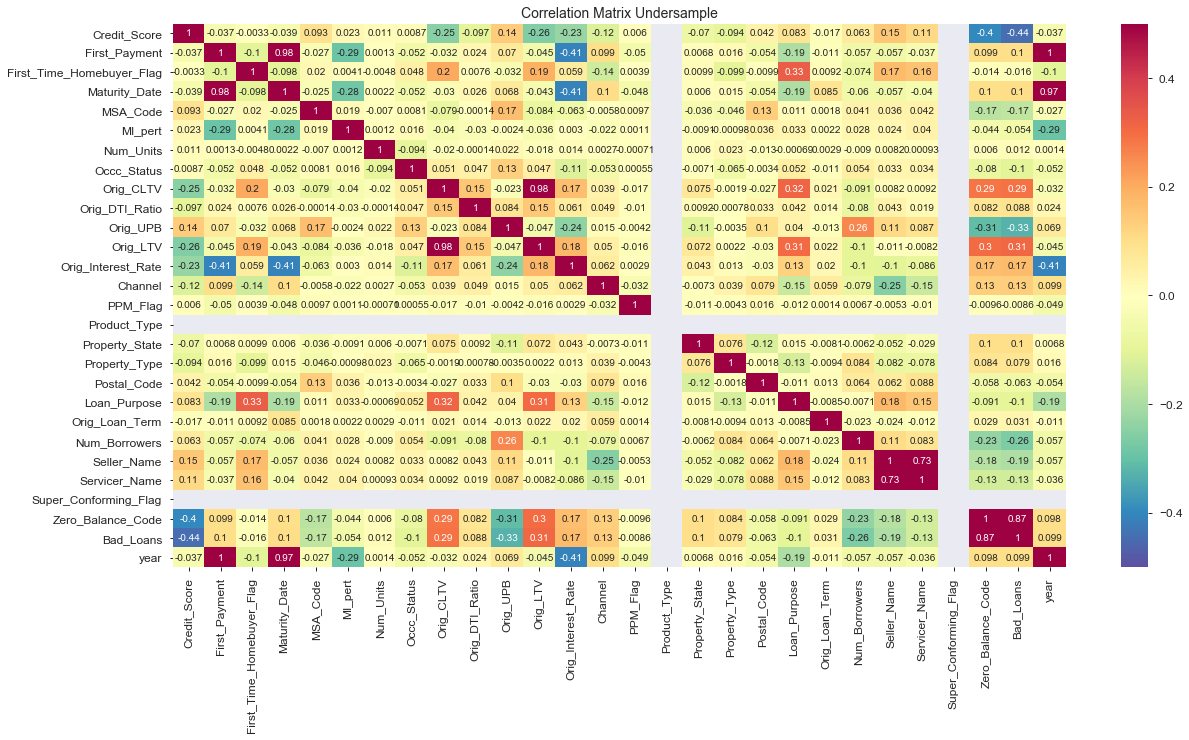

In [37]:
# Sample figsize in inches
fig, ax = plt.subplots(figsize=(20,10))         
corr_df_under = old_under_sample
corr_under = corr_df_under.corr()
sns.heatmap(corr_under, cmap='Spectral_r', annot_kws={'size':10}, ax=ax, vmin = -0.5, vmax = 0.5, annot = True)
ax.set_title("Correlation Matrix Undersample", fontsize=14)
plt.show()

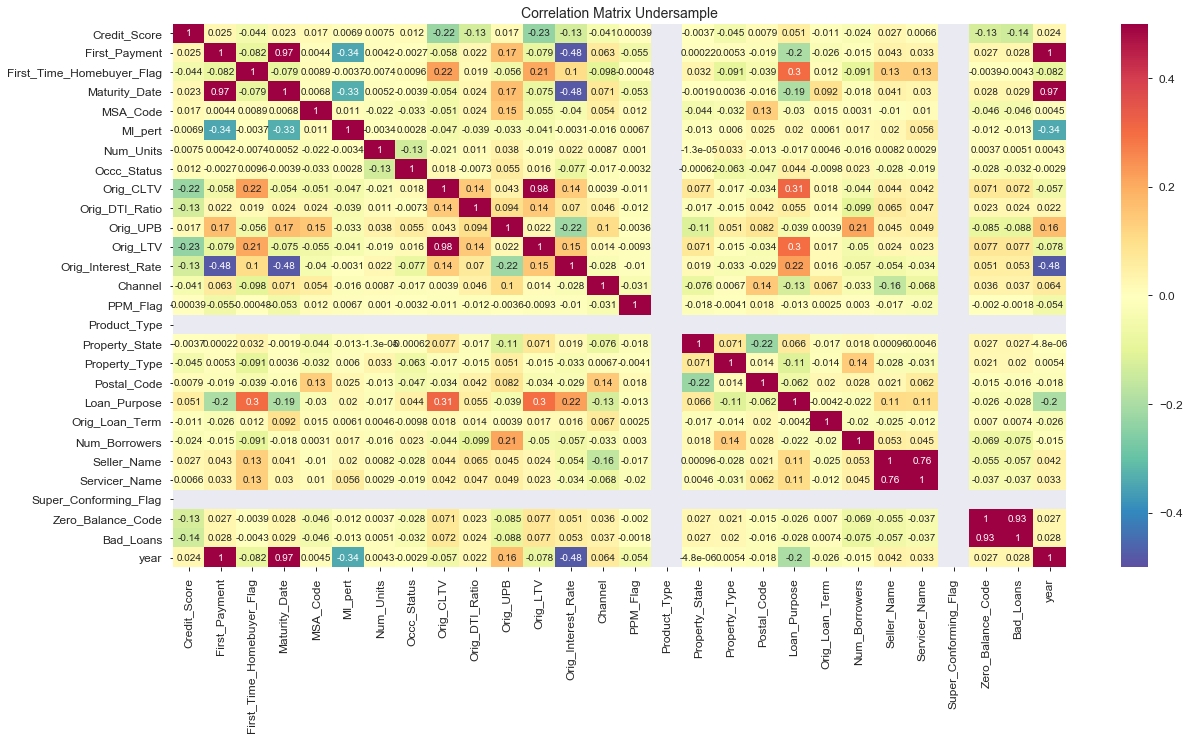

In [160]:
# Sample figsize in inches
fig, ax = plt.subplots(figsize=(20,10))         
corr_df = old_df
corr = corr_df.corr()
sns.heatmap(corr, cmap='Spectral_r', annot_kws={'size':10}, ax=ax, vmin = -0.5, vmax = 0.5, annot = True)
ax.set_title("Correlation Matrix Undersample", fontsize=14)
plt.show()

In [153]:
from sklearn.ensemble import IsolationForest, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier, EasyEnsembleClassifier

def classification_imbalanced(train_X, train_y, test_X,test_y):
    bbc_clf = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)
    brfc_clf = BalancedRandomForestClassifier(random_state=0, sampling_strategy= "auto")
    eec_clf = EasyEnsembleClassifier(random_state=0)
    
    voting_clf_hard = VotingClassifier(
    estimators=[('Balanced Bagging Classifier', bbc_clf), ('Balanced Random Forest Classfier', brfc_clf),('Easy Ensemble Classifier', eec_clf)],
    voting='hard')
    voting_clf_hard.fit(train_X, train_y)
    voting_clf = VotingClassifier(
    estimators=[('Balanced Bagging Classifier', bbc_clf), ('Balanced Random Forest Classfier', brfc_clf),('Easy Ensemble Classifier', eec_clf)],
    voting='soft')
    voting_clf.fit(train_X, train_y)
    
    y_pred_train_all = pd.DataFrame(data = pd.Series(train_y))
    y_pred_test_all= pd.DataFrame(data = pd.Series(test_y))
    
    for clf in ( bbc_clf, brfc_clf,eec_clf, voting_clf_hard, voting_clf):
        start_time = time.time()
        clf.fit(train_X, train_y)
        y_pred_train = clf.predict(train_X)
        y_pred_test = clf.predict(test_X)
       
        y_pred_train_all[clf.__class__.__name__] = pd.Series(y_pred_train).values
        y_pred_test_all[clf.__class__.__name__] = pd.Series(y_pred_test).values
                   
        prediction_summary_imbalanced(clf.__class__.__name__,'Training', train_y,y_pred_train)
        prediction_summary_imbalanced(clf.__class__.__name__,'Testing',test_y, y_pred_test)    
        print("--- %s seconds ---" % (time.time() - start_time))

In [154]:
classification_imbalanced(old_X, old_y, future_X, future_y)

BalancedBaggingClassifier 
 Training 
 Balanced Accuracy Score: 0.9255352190029839 ROC AUC: 0.925535219002984 
 F1 Score: 0.23820015676276285 Matthews CC: 0.33909181445223113 
 Precision Recall fscore support (array([0.99942741, 0.13567687]), array([0.87626642, 0.97480402]), array([0.93380344, 0.23820016]), array([3559535,   70924], dtype=int64)) 
 [[3119101  440434]
 [   1787   69137]]
BalancedBaggingClassifier 
 Testing 
 Balanced Accuracy Score: 0.6565993349379498 ROC AUC: 0.6565993349379498 
 F1 Score: 0.13718227902327573 Matthews CC: 0.14184007239499355 
 Precision Recall fscore support (array([0.98328352, 0.08095241]), array([0.86400378, 0.44919489]), array([0.91979269, 0.13718228]), array([1283168,   34219], dtype=int64)) 
 [[1108662  174506]
 [  18848   15371]]
--- 125.35892510414124 seconds ---
BalancedRandomForestClassifier 
 Training 
 Balanced Accuracy Score: 0.8901645164946228 ROC AUC: 0.8901645164946227 
 F1 Score: 0.16081828595110775 Matthews CC: 0.2608208423892236 
 Pre

In [155]:
call_lgb(old_df, future_df,features,is_unbalanced_flag=True)

[1]	valid_0's auc: 0.842734
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.852335
[3]	valid_0's auc: 0.85718
[4]	valid_0's auc: 0.860484
[5]	valid_0's auc: 0.863445
[6]	valid_0's auc: 0.864936
[7]	valid_0's auc: 0.867329
[8]	valid_0's auc: 0.869148
[9]	valid_0's auc: 0.870732
[10]	valid_0's auc: 0.872025
[11]	valid_0's auc: 0.873663
[12]	valid_0's auc: 0.874702
[13]	valid_0's auc: 0.875799
[14]	valid_0's auc: 0.876893
[15]	valid_0's auc: 0.878022
[16]	valid_0's auc: 0.879112
[17]	valid_0's auc: 0.880053
[18]	valid_0's auc: 0.880701
[19]	valid_0's auc: 0.881532
[20]	valid_0's auc: 0.882413
[21]	valid_0's auc: 0.883127
[22]	valid_0's auc: 0.883559
[23]	valid_0's auc: 0.884149
[24]	valid_0's auc: 0.88467
[25]	valid_0's auc: 0.885131
[26]	valid_0's auc: 0.885891
[27]	valid_0's auc: 0.886424
[28]	valid_0's auc: 0.88683
[29]	valid_0's auc: 0.887246
[30]	valid_0's auc: 0.887704
[31]	valid_0's auc: 0.888173
[32]	valid_0's auc: 0.888495
[33]	valid_0's auc: 0.8

In [156]:
call_lgb(old_df, future_df,features_no_geo, is_unbalanced_flag=True)

[1]	valid_0's auc: 0.840305
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.84814
[3]	valid_0's auc: 0.85219
[4]	valid_0's auc: 0.855963
[5]	valid_0's auc: 0.857888
[6]	valid_0's auc: 0.859768
[7]	valid_0's auc: 0.861147
[8]	valid_0's auc: 0.862511
[9]	valid_0's auc: 0.864344
[10]	valid_0's auc: 0.865045
[11]	valid_0's auc: 0.866298
[12]	valid_0's auc: 0.867032
[13]	valid_0's auc: 0.868159
[14]	valid_0's auc: 0.869594
[15]	valid_0's auc: 0.870682
[16]	valid_0's auc: 0.871747
[17]	valid_0's auc: 0.872442
[18]	valid_0's auc: 0.873248
[19]	valid_0's auc: 0.873817
[20]	valid_0's auc: 0.874393
[21]	valid_0's auc: 0.875011
[22]	valid_0's auc: 0.875588
[23]	valid_0's auc: 0.876206
[24]	valid_0's auc: 0.876739
[25]	valid_0's auc: 0.877102
[26]	valid_0's auc: 0.877485
[27]	valid_0's auc: 0.877952
[28]	valid_0's auc: 0.878382
[29]	valid_0's auc: 0.878693
[30]	valid_0's auc: 0.878985
[31]	valid_0's auc: 0.879238
[32]	valid_0's auc: 0.879625
[33]	valid_0's auc: 0.

In [41]:
call_lgb(old_df, future_df,features_no_geo1, is_unbalanced_flag=True)

[1]	valid_0's auc: 0.837373
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.842546
[3]	valid_0's auc: 0.844939
[4]	valid_0's auc: 0.846195
[5]	valid_0's auc: 0.847592
[6]	valid_0's auc: 0.848453
[7]	valid_0's auc: 0.849621
[8]	valid_0's auc: 0.850549
[9]	valid_0's auc: 0.851225
[10]	valid_0's auc: 0.852219
[11]	valid_0's auc: 0.852822
[12]	valid_0's auc: 0.853454
[13]	valid_0's auc: 0.854052
[14]	valid_0's auc: 0.854674
[15]	valid_0's auc: 0.855133
[16]	valid_0's auc: 0.855655
[17]	valid_0's auc: 0.856093
[18]	valid_0's auc: 0.856402
[19]	valid_0's auc: 0.856772
[20]	valid_0's auc: 0.857101
[21]	valid_0's auc: 0.85752
[22]	valid_0's auc: 0.857858
[23]	valid_0's auc: 0.858313
[24]	valid_0's auc: 0.858609
[25]	valid_0's auc: 0.858754
[26]	valid_0's auc: 0.858984
[27]	valid_0's auc: 0.859221
[28]	valid_0's auc: 0.859424
[29]	valid_0's auc: 0.85967
[30]	valid_0's auc: 0.859823
[31]	valid_0's auc: 0.860028
[32]	valid_0's auc: 0.860188
[33]	valid_0's auc: 0.

In [42]:
call_lgb(old_df, future_df,features_no_credit_score, is_unbalanced_flag=True)

[1]	valid_0's auc: 0.822798
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.831987
[3]	valid_0's auc: 0.836017
[4]	valid_0's auc: 0.838727
[5]	valid_0's auc: 0.841346
[6]	valid_0's auc: 0.843894
[7]	valid_0's auc: 0.845474
[8]	valid_0's auc: 0.847951
[9]	valid_0's auc: 0.849834
[10]	valid_0's auc: 0.851599
[11]	valid_0's auc: 0.852836
[12]	valid_0's auc: 0.854479
[13]	valid_0's auc: 0.855897
[14]	valid_0's auc: 0.857255
[15]	valid_0's auc: 0.858385
[16]	valid_0's auc: 0.859269
[17]	valid_0's auc: 0.860158
[18]	valid_0's auc: 0.860963
[19]	valid_0's auc: 0.86181
[20]	valid_0's auc: 0.862877
[21]	valid_0's auc: 0.863552
[22]	valid_0's auc: 0.864377
[23]	valid_0's auc: 0.864944
[24]	valid_0's auc: 0.865844
[25]	valid_0's auc: 0.866547
[26]	valid_0's auc: 0.867067
[27]	valid_0's auc: 0.867416
[28]	valid_0's auc: 0.868033
[29]	valid_0's auc: 0.868468
[30]	valid_0's auc: 0.868928
[31]	valid_0's auc: 0.869337
[32]	valid_0's auc: 0.87008
[33]	valid_0's auc: 0.

Light LGB 
 Testing 
 Balanced Accuracy Score: 0.7316726298022836 ROC AUC: 0.7316726298022836 
 F1 Score: 0.13213524249219055 Matthews CC: 0.17029639991819767 
 Precision Recall fscore support (array([0.98964681, 0.07294337]), array([0.7624481 , 0.70089716]), array([0.86131673, 0.13213524]), array([1283168,   34219], dtype=int64)) 
 [[978349 304819]
 [ 10235  23984]]


Saving figure Credit_cumhist


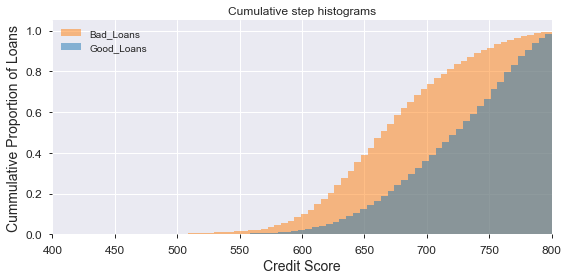

In [117]:
good_loans = result[result['Bad_Loans']==0]
bad_loans = result[result['Bad_Loans']==1]
fig, ax = plt.subplots(figsize=(8, 4))
n, bins, patches = ax.hist(bad_loans['Credit_Score'],100, density=True, histtype='stepfilled',
                           cumulative=True, label='Bad_Loans',alpha = 0.5,color = 'C1')
n, bins, patches = ax.hist(good_loans['Credit_Score'],100, density=True, histtype='stepfilled',
                           cumulative=True, label='Good_Loans', alpha = 0.5,color='C0')
# tidy up the figure
#ax.grid(True)
ax.legend(loc='upper left')
ax.set_title('Cumulative step histograms')
ax.set_xlabel('Credit Score')
ax.set_ylabel('Cummulative Proportion of Loans')
ax.set_xlim(400,800)
save_fig('Credit_cumhist')
plt.show()


In [134]:
sum(future_df['Bad_Loans']==1),len(future_df),sum(future_df['Bad_Loans']==1)/len(future_df)

(34219, 1317387, 0.02597490335034428)

In [135]:
25633/34219,(25633+320011)/1317387

(0.7490867646629066, 0.26237089025472393)

In [170]:
future_df['Orig_UPB'].median()

152000.0

In [163]:
len(future_df)

1317387

In [ ]:
# for ROC curve
"""fpr, tpr, thresholds = roc_curve(test['Bad_Loans'], ypred_lgb_test)

def plot_roc_curve(fpr, tpr,thres, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr,thresholds)
save_fig("roc_curve_plot")
plt.show()"""

In [ ]:
#fbeta_score(future_y, y_pred_future_forest,2)